# Домашнее задание № 2. Мешок слов

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('labeled.csv/labeled.csv')

In [3]:
data.loc[1010:1015]

,comment,toxic
1010,В спорт зал похожу тогда и зеркало можно. А по...,0.0
1011,"Позвольте узнать, скольких детей вы воспитали,...",0.0
1012,Не дает на 4м свидании-не стоит тратить время.,0.0
1013,"Мне похер на оценки.Всегда пишу то,что думаю.",0.0
1014,"Передайте , который меня в чс кинул, что это н...",0.0
1015,"А сейчас там ботов больше чем живых, по сути т...",0.0


In [4]:
data.toxic.value_counts(normalize=True), data.shape

(0.0    0.66514
 1.0    0.33486
 Name: toxic, dtype: float64,
 (14412, 2))

In [5]:
train, test = train_test_split(data, test_size=0.1, shuffle=True)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

## Задание 1 (3 балла)

У векторайзеров в sklearn есть встроенная токенизация на регулярных выражениях. Найдите способ заменить её на кастомную токенизацию

Обучите векторайзер с дефолтной токенизацией и с токенизацией razdel.tokenize. Обучите классификатор (любой) с каждым из векторизаторов. Сравните метрики и выберите победителя. 

(в вашей тетрадке должен быть код обучения и все метрики; если вы сдаете в .py файлах то сохраните полученные метрики в отдельном файле или в комментариях)

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from razdel import tokenize

In [71]:
vectorizer = CountVectorizer()
train_V_dt = vectorizer.fit_transform(train.comment)
test_V_dt = vectorizer.transform(test.comment)

In [72]:
vectorizer = CountVectorizer(tokenizer=lambda x: [w.text for w in tokenize(x)])
train_V_rt = vectorizer.fit_transform(train.comment)
test_V_rt = vectorizer.transform(test.comment)

In [79]:
LR_for_dt = LogisticRegression(solver="liblinear")
LR_for_rt = LogisticRegression(solver="liblinear")

In [80]:
LR_for_dt.fit(train_V_dt, train.toxic)
LR_for_rt.fit(train_V_rt, train.toxic)

LogisticRegression(solver='liblinear')

In [81]:
pred_on_Vdt = LR_for_dt.predict(test_V_dt)
pred_on_Vrt = LR_for_rt.predict(test_V_rt)

In [76]:
from sklearn.metrics import classification_report

In [82]:
print(classification_report(pred_on_Vdt, test.toxic))

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      1069
         1.0       0.70      0.87      0.78       373

    accuracy                           0.87      1442
   macro avg       0.82      0.87      0.84      1442
weighted avg       0.89      0.87      0.87      1442



In [83]:
print(classification_report(pred_on_Vrt, test.toxic))

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91      1036
         1.0       0.75      0.85      0.80       406

    accuracy                           0.88      1442
   macro avg       0.84      0.87      0.86      1442
weighted avg       0.89      0.88      0.88      1442



Сравнивая classification_report для логистической регрессии, обученной на частотном векторайзере с дефолтным токенизатором и токенизатором razdel, видим, что последний показывает несколько лучшие результаты - чаще определяет токсичные тексты

## Задание 2 (3 балла)

Преобразуйте таблицу с абсолютными частотностями в семинарской тетрадке в таблицу с tfidf значениями. (Таблица - https://i.ibb.co/r5Nc2HC/abs-bow.jpg) Формула tfidf есть в семинаре на картнике с пояснениями на английском. 
Считать нужно в питоне. Формат итоговой таблицы может быть любым, главное, чтобы был код и можно было воспроизвести вычисления. 

In [6]:
import re
import numpy as np

In [7]:
# запишем предложения с рисунка
sentences = ['я и ты', 'ты и я', 'я, я и только я', 'только не я', 'он']

In [8]:
# токенизируем их
sent_words = [re.findall(r'\w+', t) for t in sentences]

In [9]:
# вспомогательная функция для нахождения уникальных токенов
def flatten(l):
    return [item for sublist in l for item in sublist]

In [10]:
sent_words

[['я', 'и', 'ты'],
 ['ты', 'и', 'я'],
 ['я', 'я', 'и', 'только', 'я'],
 ['только', 'не', 'я'],
 ['он']]

In [11]:
# находим уникальные токены
unique_words = list(set(flatten(sent_words)))

In [12]:
unique_words

['он', 'ты', 'я', 'только', 'не', 'и']

In [13]:
# создаем матрицу из нулей для подсчета частоты слов
tf_matrix = np.zeros((len(sentences), len(unique_words)))

In [15]:
# считаем частоту уникальных слов для каждого документа
# i - индекс уникального слова
# j - индекс документа
for i in range(len(unique_words)):
    for j in range(len(sent_words)):
        tf_matrix[j][i] = sentences[j].count(unique_words[i])

In [16]:
tf_matrix

array([[0., 1., 1., 0., 0., 1.],
       [0., 1., 1., 0., 0., 1.],
       [0., 0., 3., 1., 0., 1.],
       [0., 0., 1., 1., 1., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [17]:
# посчитаем idf каждого слова - возьмем логарифм от 
# частного кол-ва документов и вектора с кол-вом ненулевых частот для каждого слова
idf = np.log(tf_matrix.shape[0] / sum(tf_matrix != 0))

In [29]:
# домножим матрицу тф на вектор идф
tf_idf_matrix = tf_matrix * idf

In [30]:
print(tf_idf_matrix)

[[0.         0.91629073 0.22314355 0.         0.         0.51082562]
 [0.         0.91629073 0.22314355 0.         0.         0.51082562]
 [0.         0.         0.66943065 0.91629073 0.         0.51082562]
 [0.         0.         0.22314355 0.91629073 1.60943791 0.        ]
 [1.60943791 0.         0.         0.         0.         0.        ]]


## Задание 3 (2 балла)

Обучите 2 любых разных классификатора из семинара. Предскажите токсичность для текстов из тестовой выборки (используйте одну и ту же выборку для обоих классификаторов) и найдите 10 самых токсичных для каждого из классификаторов. Сравните получаемые тексты - какие тексты совпадают, какие отличаются, правда ли тексты токсичные?

Требования к моделям:   
а) один классификатор должен использовать CountVectorizer, другой TfidfVectorizer  
б) у векторайзера должны быть вручную заданы как минимум 5 параметров (можно ставить разные параметры tfidfvectorizer и countvectorizer)  
в) у классификатора должно быть задано вручную как минимум 2 параметра (по возможности)  
г)  f1 мера каждого из классификаторов должна быть минимум 0.75  

*random_seed не считается за параметр

In [50]:
from sklearn.naive_bayes import MultinomialNB

In [51]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer, wordpunct_tokenize

[nltk_data] Downloading package stopwords to C:\Users\PC
[nltk_data]     Natalya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Сравним два токенайзера и выберем наиболее подходящий на примере текста 1012 (тут интересно употребление дефиса вместо положенного тире)

In [173]:
TweetTokenizer().tokenize(data.comment[1012])

['Не', 'дает', 'на', '4м', 'свидании-не', 'стоит', 'тратить', 'время', '.']

In [176]:
wordpunct_tokenize(data.comment[1012])

['Не',
 'дает',
 'на',
 '4м',
 'свидании',
 '-',
 'не',
 'стоит',
 'тратить',
 'время',
 '.']

На данном примере лучше работает wordpunct_tokenize, поэтому выберем его. Но возможно, что TweetTokenizer где-то сработает лучше

In [55]:
stop_words_ru = nltk.corpus.stopwords.words('russian')

Сначала обучим MultinomialNB на CountVectorizer, поскольку это наиболее классическое решение для текстовой классификации

Параметров для модели MultinomialNB всего 3, и те лучше оставить дефолтными, поэтому их не трогаем. Настроим параметры для векторайзера:
* минимальная частота слова в словаре 4,
* "значения частоты бинарны" - 0/1,
* токенизируем с помощью wordpunct_tokenize, который мы выбрали выше,
* стоп-слова возьмем из nltk + знаки пунктуации,
* игнорируем слова, встречающиеся более чем в 2% документов (качество модели особо не падает, нужно для определения токсичных слов)

In [256]:
import string
puncts = list(string.punctuation)
stop_words_ru = stop_words_ru.extend(puncts)

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

In [315]:
cv = CountVectorizer(min_df=4, binary=True, tokenizer=wordpunct_tokenize, stop_words=stop_words_ru, max_df=0.02)

In [316]:
train_cv = cv.fit_transform(train.comment)
test_cv = cv.transform(test.comment)

In [317]:
NB_count = MultinomialNB()
NB_count.fit(train_cv, train.toxic)
pred_toxic_cv = NB_count.predict(test_cv)

In [318]:
print(classification_report(pred_toxic_cv, test.toxic))

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90      1036
         1.0       0.71      0.84      0.77       406

    accuracy                           0.86      1442
   macro avg       0.82      0.86      0.84      1442
weighted avg       0.87      0.86      0.86      1442



In [221]:
NB_count.classes_

array([0., 1.])

In [225]:
import seaborn as sns

<AxesSubplot:>

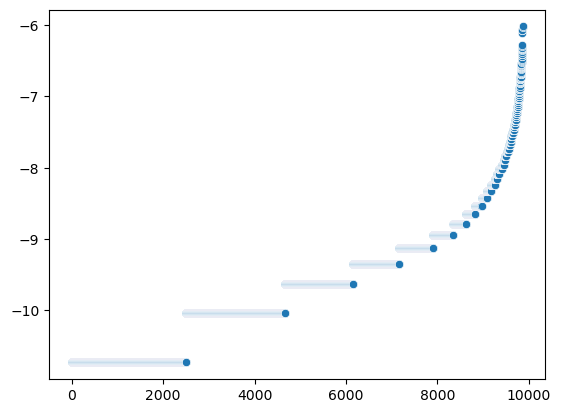

In [319]:
sns.scatterplot(data=np.sort(NB_count.feature_log_prob_[1]))

**Топ-10 самых вероятных слов для токсичных текстов**

In [320]:
for arg in np.argsort(NB_count.feature_log_prob_[1])[:-10:-1]:
    print(cv.get_feature_names_out()[arg])

нахуй
себя
вас
теперь
хохлы
хохлов
ему
себе
пиздец


**Топ-10 самых вероятных слов для нетоксичных текстов**

In [321]:
for arg in np.argsort(NB_count.feature_log_prob_[0])[:-10:-1]:
    print(cv.get_feature_names_out()[arg])

например
знаю
4
пока
стоит
деньги
вроде
который
всегда


**Топ-10 самых токсичных текстов**

In [370]:
i = 1
for a in np.argsort(NB_count.predict_proba(test_cv)[:, 1])[:-11:-1]:
    print(i, test.toxic[a], test.comment[a])
    i += 1

1 1.0 Как известно, у Укр ины (т.е. окр ины), слепленной по пьяни на коленке во 2-м десятилетии XX в., нет истории до XX столетия. Все земли, которые сейчас занимает Укр ина, это русские, румынские, польские и венгерские земли. Напоминаем, что укр инство это сугубо левацкая, антиконсервативная местечково-хуторская идеология, направленная, как и прочие левацкие идеи, на разделение больших наций и поддержание диктата интернацистов. Сторонники бандеровцев (леваков, выступавших за бесклассовое общество и борьбу с капитализмом) и карлика-душителя котов Степана Бандеры, который, как известно, боролся с расизмом, поддерживал Идель-Урал и называл побратимами исламских борцов за свободу из Азербайджана, не пользуются симпатиями у правых европейцев. И это правильно. Попытки заявить о некой отдельной нации неких украинцев это манипуляции, созданные с целью оторвать от русских часть их этнических земель и ослабить в будущем Россию. Только так, чудовищной ложью и тотальной пропагандой, фейковая нац

Тексты отобрались действительно токсичные. Тут без лишних комментариев

Теперь обучим тоже простой алгоритм KNeighborsClassifier, используя векторайзер TfIdf

Для TfIdf зададим
* все тот же токенизатор,
* все те же стоп-слова

Для KNeighborsClassifier установим
* количество соседей,
* "веса, инверсируемые по расстоянию",
* алгоритм поиска ближайших соседей - brute-force search

In [157]:
from sklearn.neighbors import KNeighborsClassifier

In [330]:
tiv = TfidfVectorizer(tokenizer=wordpunct_tokenize, stop_words=stop_words_ru, max_df=0.05)

In [331]:
train_tiv = tiv.fit_transform(train.comment)
test_tiv = tiv.transform(test.comment)

In [332]:
knn = KNeighborsClassifier(n_neighbors=9, weights='distance', algorithm='brute')
knn.fit(train_tiv, train.toxic)
pred_toxic_tiv_knn = knn.predict(test_tiv)

In [333]:
print(classification_report(pred_toxic_tiv_knn, test.toxic))

              precision    recall  f1-score   support

         0.0       0.93      0.81      0.87      1105
         1.0       0.57      0.81      0.67       337

    accuracy                           0.81      1442
   macro avg       0.75      0.81      0.77      1442
weighted avg       0.85      0.81      0.82      1442



**Топ-10 самых токсичных текстов**

In [371]:
i = 1
for a in np.argsort(knn.predict_proba(test_tiv)[:, 1])[:-11:-1]:
    print(i, test.toxic[a], test.comment[a])
    i += 1

1 0.0 Хэллоуин 2018 года ведь шлак полный, и оценка у него 5.8.

2 1.0 Опять хохлы из киберсотни на куриную косточку капчуют.

3 1.0 Фильмы Груз 200 и Кочегар - смрад полный, только в голове психически нездорового человека может родиться такой сценарий.

4 1.0 Хохол насиловал жертву около часа Вот это ебарь

5 1.0 Зальете шебм? Вот этот кун. Говорит, будто заявление забрали. Алсо как-то и не скажешь, что он станет совать хуй в очъко тян, а потом обмазывать ей губы, лол. Фу нахуй. Алсо, мне думается, что пиздит

6 1.0 Что-то не связал в единое: каратист - очкарик Пичужкин самка Эльцина (гори в аду тварь).

7 1.0 Типа есть, чем думать. Лично мне жаль, что его не у бало, как следует. На премию Дарвина прямой кандидат.

8 1.0 Стас, никому, кроме тебя и армии твоих подсосов(которые представляют собой типичный дегенеративный биомусор, ведущийся на любые скандалы-интриги), твои ролики нахуй не нужны. Серьёзно, ты сделал новости с целью показать, что такое говно может делать любой, а аудитория

Как и в прошлом случае, неправильно определен всего 1 текст. И он, как и в прошлом случае, сильно негативно окрашен и по словарю близок к токсичным текстам.

Также можно отметить, что в обеих моделях есть схожие тексты в топе токсичности (например, 5 и 8)

## *Задание 4 (2 балла)

Для классификаторов LogisticRegression и Random Forest найдите способ извлечь важность признаков для предсказания токсичного класса. Сопоставьте полученные числа со словами (или нграммами) в словаре и найдите топ - 5 "токсичных" слов для каждого из классификаторов. 

Важное требование: в топе не должно быть стоп-слов. Для этого вам нужно будет правильным образом настроить векторизацию.

In [374]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_tiv, train.toxic) # для train_tiv выше настроена фильтрация стоп-слов

LogisticRegression()

In [382]:
for i in np.argsort(lr.coef_[0])[:-10:-1]:
    print(tiv.get_feature_names_out()[i])

тебя
хохлы
хохлов
тебе
нахуй
блять
пиздец
дебил
блядь


In [383]:
from sklearn.ensemble import RandomForestClassifier

RFC_tfidf = RandomForestClassifier(max_depth=10, max_features='log2', class_weight='balanced_subsample')
RFC_tfidf.fit(train_tiv, train.toxic)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features='log2')

In [389]:
for j in np.argsort(RFC_tfidf.feature_importances_)[:-10:-1]:
    print(tiv.get_feature_names_out()[j])

русские
банк
очень
хохлов
тебя
много
пиздец
сука
тебе
